<figure>
<img src="../Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Elimina ruido en fotos</center>

**<center>Convolucional autoencoder</center>**

##   <span style="color:blue">Profesores</span>

##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Campo Elías Pardo Turriago, cepardot@unal.edu.co 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

5. Oleg Jarma, ojarmam@unal.edu.co 
6. Laura Lizarazo, ljlizarazore@unal.edu.co 

## <span style="color:blue">Contenido</span> 

* [Introducción](#Introducción)
* [Autocodificador o autoencoder](#Autocodificador-o-autoencoder)
* [Importa módulos](#Importa-módulos)
* [Parámetros de la red](#Parámetros-de-la-red)
* [Codificador](#Codificador)
* [Decodificador](#Decodificador)
* [Auto-codificador](#Auto-codificador)
* [Entrenamiento](#Compila)
* [Recuperación de imágenes](#Recuperación-de-imágenes)
* [Representación latente](#Representación-latente)

## <span style="color:blue">Introducción</span>

En este cuaderno se implementa un Autoencoder  para la recosntrucción de rostros conjunto de datos [LFW](http://vis-www.cs.umass.edu/lfw/) (**Labeled Faces in the Wild**). 

Basado en [Autoencoders for Image Reconstruction in Python and Keras](https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/)

- [Deep Aligned paper](http://vis-www.cs.umass.edu/papers/nips2012_deep_congealing.pdf)

## <span style="color:blue">Importar y procesar imágenes</span>

In [1]:
#importar open cv                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ii!conda install -c conda-forge opencv
import cv2
#importar pandas para manejo de dataframes
import pandas as pd
# import tarfile para manejo de archivos comprimidos
import tarfile
# Barra de progreso
from tqdm.notebook import tqdm
# Manejo de archivos del computador
import os
# Manejo de gráficos
import matplotlib.pyplot as plt
# Manejo de Arreglos
import numpy as np

In [2]:
# Metadata de los datos y algunas características
# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt

path="../Data"
path2="../Imagenes_Model"
path3="../Output"

if os.path.isdir(path) and os.path.isdir(path2) and os.path.isdir(path3):
    print("Ya existen los directorios")
else:
    os.mkdir(path)
    os.mkdir(path2)
    os.mkdir(path3)
    !wget -O ../Data/lfw_attributes.txt http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
    !wget -O ../Data/lfw-deepfunneled.tgz http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
    !wget -O ../Data/lfw.tgz http://vis-www.cs.umass.edu/lfw/lfw.tgz

ATTRS_NAME = "../Data/lfw_attributes.txt"

# Imágenes usando DeepFunneled (Menos Espacio)
# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz

IMAGES_NAME = "../Data/lfw-deepfunneled.tgz"

# Imágenes completas
# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = "../Data/lfw.tgz"

Ya existen los directorios


Se construyen funciones para leer y preprocesar los datos usando OpenCV

In [3]:
## Función  para decodificar las imágenes bajadas desde datos crudos (bytes)
def decode_image_from_raw_bytes(raw_bytes):
    # Decodificar desde archivos crudos en formato adecuado, flag =1 significa leer en BGR
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    #Convertir a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

Procesamiento individual

In [4]:
indice=2
#indice=slice(3)

with tarfile.open(RAW_IMAGES_NAME) as f:
    m=f.getmembers()[indice]
    print(m)
    img=decode_image_from_raw_bytes(f.extractfile(m).read())
    print(img.shape)

<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7fc7a417a580>
(250, 250, 3)


In [5]:
with tarfile.open(RAW_IMAGES_NAME) as f:
    m=f.getmembers()[indice]
    raw_bytes=f.extractfile(m).read()
    print(bytearray(raw_bytes)[0:10])

bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF')


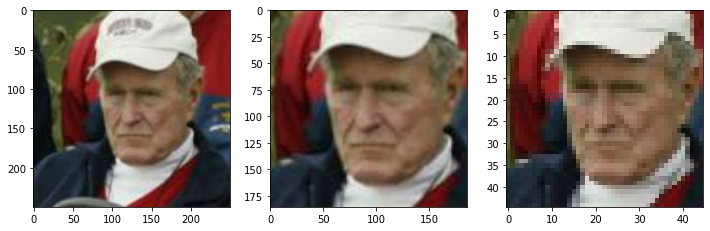

In [6]:
plt.figure(figsize=(12,5))

plt.subplot(131)
plt.imshow(img)

dx=32
dy=32
img_new=img[dx:-dx,dy:-dy]
plt.subplot(132)
plt.imshow(img_new)

dimx=45
dimy=45

img_new=cv2.resize(img_new, (dimx, dimy))
plt.subplot(133)
plt.imshow(img_new)

plt.show()

In [7]:
### Función para bajar las imagenes del .tgz y preprocesarlas sistemáticamente
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Leer archivo lfw_attributes.txt y hacer una limpieza inicial
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    # Corrimiento de carácteres incorrectos
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    # Filtrar nombres de personas y numeros de imagen (por persona), convertir a conjunto
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Leer Fotos e identificación
    all_photos = []
    photo_ids = []

    # Abrir archivo .tgz sin descomprimir
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        # tqdm se usa para mostrar la barra de progreso
        for m in tqdm(f.getmembers()):
            # Solo procesa los archivos desde el archivo comprimido que sean realmente imágenes (.jpg)
            if m.isfile() and m.name.endswith(".jpg"):
                # Descomprimir archivo desde el comprimido y convertir a RGB
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Recortar lo que sean caras y cambiar tamaño
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Obtener nombre de la persona y agregarlo a la colección de datos
                fname = os.path.split(m.name)[-1]
                # La razón de -4 es para quitar la extensión .jpg
                fname_splitted = fname[:-4].replace('_', ' ').split()
                # Sacar la identificación del nombre
                person_id = ' '.join(fname_splitted[:-1])
                # Sacar el número de foto por separado
                photo_number = int(fname_splitted[-1])
                # Comparar los metadatos con las fotos reales (DEBEN COINCIDIR)
                if (person_id, photo_number) in imgs_with_attrs:
                    # Cuando coinciden, agregar las fotos
                    all_photos.append(img)
                    # Y también agregar la identidad de las personas
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})
                    
    # Hacer un dataframe con los resultados
    photo_ids = pd.DataFrame(photo_ids)
    # UNir las imágenes en un tensor 4D
    all_photos = np.stack(all_photos).astype('uint8')

    # Preservar el orden de encontrados en búsqueda
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs, photo_ids

In [8]:
# Obtener el conjunto de datos sin descomprimir
dim_x=56
dim_y=56
X, attr,names = load_lfw_dataset(use_raw=True, dimx=dim_x, dimy=dim_y)

  0%|          | 0/18983 [00:00<?, ?it/s]

In [9]:
X.shape

(13143, 56, 56, 3)

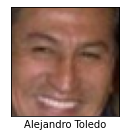

In [10]:
azar=np.random.randint(len(X))

plt.figure(figsize=(2,2))
plt.imshow(X[azar])
plt.xticks([])
plt.yticks([])
plt.xlabel(names.person[azar])
plt.show()

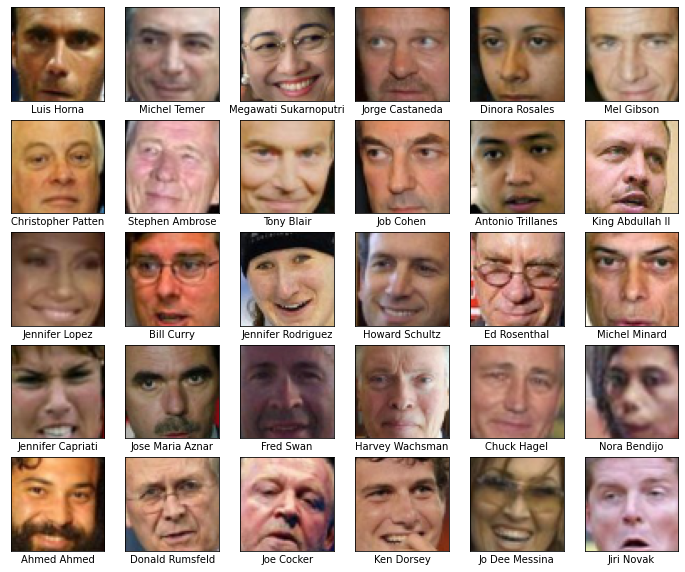

In [11]:
plt.figure(figsize=(12,10))

numero_muestras=30

muestra=np.random.randint(0,len(X),numero_muestras)

for i in range(numero_muestras):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[muestra[i]])
    plt.xlabel(names.person[muestra[i]])

plt.show()

In [12]:
X = X.astype('float32') / 255.0
#X = X - 0.5

## <span style="color:blue">Importa módulos</span>



In [13]:
# Importar tensorflow
import tensorflow as tf
# Importar Backend
from keras import backend as K
# importar layers apropiados para la Red
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
# Graficar modelo
from tensorflow.keras.utils import plot_model
# Importar optimizadores
from tensorflow.keras.optimizers import Adam, Adamax
# Importar Función de Pérdida
from tensorflow.keras.losses import MeanSquaredError
# Función parar separar datos de entrenamiento y validación
from sklearn.model_selection import train_test_split

## <span style="color:blue">Parámetros de la red Codificadora</span>


In [14]:
# network parameters
input_shape = (dim_x, dim_y, 3)

kernel_size = 3
latent_dim = 512
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32,64,128]
    
# Train parameters
epochs = 20
batch_size = 64

## <span style="color:blue">Codificador: encoder</span>


In [ ]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
  x = Conv2D(filters=filters,
             kernel_size=kernel_size,
             strides=2,
             activation='relu',
             padding='same')(x)

shape = K.int_shape(x)
# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')


encoder.summary()
#plot_model(encoder, to_file='../Imagenes_Model/encoder_conv_lfw.png', show_shapes=True)

## <span style="color:blue">Decodificador: decoder</span>


In [16]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (13, 13, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,
  kernel_size=kernel_size,
  strides=2,
  activation='relu',
  padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

decoder.summary()

#plot_model(decoder, to_file='../Imagenes_Model/decoder_conv_lfw.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 6272)              3217536   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 56, 56, 32)       1846

## <span style="color:blue">Auto-codificador: auto-encoder</span>


In [17]:
# Autoencoder Model
autoencoder = Model(inputs=inputs, 
                    outputs=decoder(encoder(inputs)),
                    name='autoencoder_lfw_model')

#Summary
autoencoder.summary()
plot_model(autoencoder, to_file='../Imagenes_Model/autoencoder_conv_lfw.png',show_shapes=True)

Model: "autoencoder_lfw_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 56, 56, 3)]       0         
                                                                 
 encoder (Functional)        (None, 512)               3305024   
                                                                 
 decoder (Functional)        (None, 56, 56, 3)         3458243   
                                                                 
Total params: 6,763,267
Trainable params: 6,763,267
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## <span style="color:blue">Entrenamiento</span>

### Compila

In [18]:
# Usaremos el optimizador Adamax (Pruebe otros y note diferencias)
optimizer = Adamax(learning_rate=1e-3)
# Se usará el error cuadrático medio
loss_fn = MeanSquaredError()
# Compilar autoencoder
autoencoder.compile(optimizer= optimizer, loss = loss_fn)

### Separar Datos

In [19]:
# Separar datos en entrenamiento y validación interna
X_train,X_test=train_test_split(X,test_size=0.1, random_state=42)

In [20]:
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

### Epochs

In [ ]:
 for i in range(25):
  print("Epoch %i/25, Generating corrupted samples..."%(i+1))
  X_train_noise = apply_gaussian_noise(X_train)

  # Entrenar el modelo con los ejemplos ruidosos de entrada y etiquetas limpias de salida
  autoencoder.fit(x=X_train_noise, y=X_train, epochs=5,validation_split=0.1)

In [39]:
os.makedirs('../Models',exist_ok=True)

In [43]:
autoencoder.save('../Models/conv_autoencoder.h5')

## Uso del Modelo 

In [41]:
autoencoder = tf.keras.models.load_model('../Models/conv_autoencoder.h5')

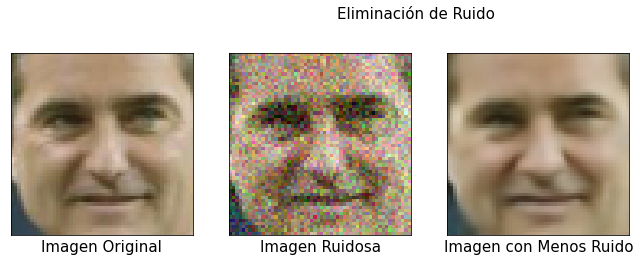

In [44]:
X_test_noise = apply_gaussian_noise(X_test)

azar=np.random.randint(len(X_test_noise))

plt.figure(figsize=(15,4))
plt.suptitle("Eliminación de Ruido",fontsize=15)

plt.subplot(1,4,1)
plt.imshow(np.clip(X_test[azar]+0,0,1))
plt.xticks([])
plt.yticks([])
plt.xlabel("Imagen Original",fontsize=15)

plt.subplot(1,4,2)
plt.imshow(np.clip(X_test_noise[azar]+0,0,1))
plt.xticks([])
plt.yticks([])
plt.xlabel("Imagen Ruidosa",fontsize=15)

plt.subplot(1,4,3)
no_noise=autoencoder.predict(X_test_noise[azar].reshape(1,dim_x,dim_y,3))
plt.imshow(np.clip(no_noise.reshape(dim_x,dim_y,3)+0,0,1))
plt.xticks([])
plt.yticks([])
plt.xlabel("Imagen con Menos Ruido",fontsize=15)

plt.show()